In [1]:
from pcntoolkit.util.hbr_utils import *
import scipy

import os
import pickle
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import pcntoolkit as ptk
from itertools import product
from functools import reduce
from pcntoolkit.model.SHASH import SHASHb, SHASH, SHASHo
from pcntoolkit.util.utils import scaler
from scipy.stats import gaussian_kde
import pymc3 as pm
import scipy.special as spp
import arviz as av
from scipy.stats import skew, kurtosis
import time
cols = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

In [2]:
projdir = '/project_cephfs/3022017.02/projects/stijdboe/make_results/more_flexible_models_lifespan_big/'
data_dir = '/project_cephfs/3022017.02/projects/stijdboe/Data'
lifespan_fold_data_dir = os.path.join(data_dir,'10_folds_sexcov','fold_0')
umap_data_dir = os.path.join(data_dir,'UMAP_data')
features = ['Right-Cerebellum-White-Matter',
            'EstimatedTotalIntraCranialVol',
            'Right-Lateral-Ventricle',
            'WM-hypointensities',
            'rh_S_interm_prim-Jensen_thickness', 
            'Brain-Stem']

In [3]:
datasets = ['UMAP']

model_names = ['Normal','SHASHb_1','SHASHb_2']
likelihood_map = {'SHASHb_1':'SHASHb','SHASHb_2':'SHASHb','Normal':'Normal'}
durationmap = {'Normal':'05:00:00','SHASHb':'05:00:00'}
epsilon_linear_map = {'SHASHb_1':'False','SHASHb_2':'True','Normal':'False'}
delta_linear_map = {'SHASHb_1':'False','SHASHb_2':'True','Normal':'False'}
# For each config

# epsilon_confs = ['False']
# delta_confs = ['False']
# For each dataset
all_data = {}
inscalers = {}
models = {}
maps = {}
testXs = {}
for d in datasets:
    if d == 'UMAP':
        X_train =np.loadtxt(os.path.join(umap_data_dir, 'cov_tr.txt'))
        Y_train =np.loadtxt(os.path.join(umap_data_dir, 'trainselect.txt'))
        
        X_test =np.loadtxt(os.path.join(umap_data_dir, 'cov_te.txt'))
        Y_test =np.loadtxt(os.path.join(umap_data_dir, 'testselect.txt'))     
        Z_test = np.zeros_like(Y_test).astype(int)
        UMAP_data = X_train, Y_train, X_test, Y_test, Z_test

    else:
        with open(os.path.join(lifespan_fold_data_dir, 'X_train.pkl'),'rb') as file:
                  X_train = pickle.load(file).to_numpy()
        with open(os.path.join(lifespan_fold_data_dir, f'{d}train.pkl'),'rb') as file:
                  Y_train = pickle.load(file).to_numpy()
        with open(os.path.join(lifespan_fold_data_dir, 'Z_train.pkl'),'rb') as file:
                  Z_train = pickle.load(file).to_numpy()
        with open(os.path.join(lifespan_fold_data_dir, 'X_test.pkl'),'rb') as file:
                  X_test = pickle.load(file).to_numpy()
        with open(os.path.join(lifespan_fold_data_dir, f'{d}test.pkl'),'rb') as file:
                  Y_test = pickle.load(file).to_numpy()
        with open(os.path.join(lifespan_fold_data_dir, 'Z_test.pkl'),'rb') as file:
                  Z_test = pickle.load(file).to_numpy()
        if d == 'Right-Lateral-Ventricle':
            Ventricle_data = X_train, Y_train, Z_train, X_test, Y_test, Z_test
    testXs[d] = X_test.copy()

    for mn in model_names:
        name = mn.replace("_","")
        with open(os.path.join(projdir,'Models',f'NM_0_0_UMAP{name}.pkl'),'rb') as file:
            model = pickle.load(file)
            models[d, mn] = model
            inscaler = scaler('standardize')
            outscaler = scaler('standardize')
            inscaler.fit(X_train)
            outscaler.fit(Y_train)
            inscalers[d, mn] = inscaler
            this_X_test = inscaler.transform(X_test)
            this_Y_test = outscaler.transform(Y_test)
            X_test_transformed = model.hbr.transform_X(this_X_test)
            all_data[d,mn] = ptk.util.utils.expand_all(X_test_transformed, this_Y_test, Z_test)
        with open(os.path.join(projdir, f'MAP_{d}_{mn}.pkl'),'rb') as file:
            maps[d, mn] = pickle.load(file)

In [4]:
for i in maps.keys():
    print(i)

('UMAP', 'Normal')
('UMAP', 'SHASHb_1')
('UMAP', 'SHASHb_2')


In [5]:
zscores = {}
forwards = {}
synth_X = np.linspace(0, 100, 100)[:,None]
synth_Z = np.zeros_like(synth_X).astype(int)
synth_X = np.concatenate([synth_X, np.ones_like(synth_X)], axis = 1)
for d in datasets:
    
    for mn in model_names:
        name = mn.replace("_","")
        model = models[d, mn]
        X, Y, Z = all_data[d, mn]
        MAP = maps[d, mn]
        synth_X_sd = inscalers[d, mn].transform(synth_X)
        synth_X_trans = model.hbr.transform_X(synth_X_sd)
        this_forward = forward(synth_X_trans, synth_Z, model, MAP)
        forwards[d, mn] = this_forward
        MAP_zscores = get_single_zscores(X, Y, Z, model, MAP)[:,0]
        zscores[d, mn] = MAP_zscores.copy()
    if d == 'UMAP':
        zscores[d, 'blr'] = np.loadtxt(os.path.join(projdir, 'blr_UMAP/Z_estimate.txt'))
    else:
        batch_id = features.index(d)+1
        zscores[d, 'blr'] = np.loadtxt(f'/project_cephfs/3022017.02/projects/stijdboe/make_results/10_folds_results/fold_0_blr/batch_{batch_id}/Z_estimate.txt')

In [6]:
for i in zscores.keys():
    print(i)

('UMAP', 'Normal')
('UMAP', 'SHASHb_1')
('UMAP', 'SHASHb_2')
('UMAP', 'blr')


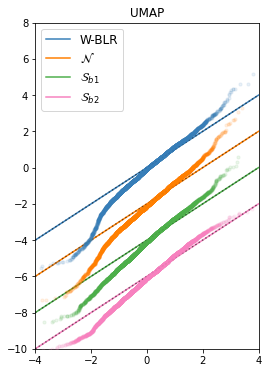

In [7]:
for ids, d in enumerate(datasets):
    fig = plt.figure(figsize=(4, 6))
    plt.xlim(-4,4)
    plt.ylim(-10,8)
    blr_z = zscores[d,'blr']
    lmap = {'blr':'W-BLR','SHASHo':'$\mathcal{S}_o$', 'SHASHb_1':'$\mathcal{S}_{b1}$','SHASHb_2':'$\mathcal{S}_{b2}$',  'Normal':'$\mathcal{N}$'}

    norm = np.random.randn(blr_z.shape[0])
    plt.scatter(np.sort(norm),np.sort(blr_z),color = cols[0], alpha = 0.1, s =10, zorder=3)
    plt.plot([-4,4],[-4,4],color = cols[0],label='W-BLR')
    plt.plot([-4,4],[-4,4], color = 'black', linestyle = ':', alpha = 0.5)

    k=0
    for ic,mn in enumerate(model_names):
        k+=1
        z = zscores[d, mn]
        label = lmap[mn]
        norm = np.random.randn(z.shape[0])

        plt.scatter(np.sort(norm), np.sort(z)-2*k,color = cols[ic+1], alpha = 0.1, s=10, zorder=3)
        plt.plot([-4,4],[-4-2*k,4-2*k], color = cols[ic+1],label=label)
        plt.plot([-4,4],[-4-2*k,4-2*k], color = 'black', linestyle = ':', alpha = 0.5)
    if ids == 0:
        plt.legend(fontsize=12)
    plt.title(d,fontsize=12)
#     plt.savefig(f"/home/preclineu/stijdboe/Projects/MasterThesis/Latex/Thesis/imgs/qqplot-complex{d}.png",dpi=300)
    plt.show()

In [8]:
scores = np.zeros((1, 4, 4))
for ids, d in enumerate(datasets):
    blr_z = zscores[d,'blr']
    scores[ids, 0, 0] = np.mean(blr_z)
    scores[ids, 0, 1] = np.var(blr_z)
    scores[ids, 0, 2] = skew(blr_z)
    scores[ids, 0, 3] = kurtosis(blr_z)
    
    for ic, mn in enumerate(model_names):
        blr_z = zscores[d,mn]
        scores[ids, ic+1, 0] = np.mean(blr_z)
        scores[ids, ic+1, 1] = np.var(blr_z)
        scores[ids, ic+1, 2] = skew(blr_z)
        scores[ids, ic+1, 3] = kurtosis(blr_z)

scores = np.round(scores, 2)

In [9]:
print(scores)

[[[-0.2   2.02 -0.48  0.99]
  [-0.19  2.   -0.27  0.63]
  [-0.18  1.86 -0.16  0.  ]
  [-0.17  1.78 -0.21 -0.17]]]


In [10]:
for ids, d in enumerate(datasets):
    # Print the skews
    print(d)
    print("Means")
    print(scores[ids,:,0])
    print("vars")
    print(scores[ids,:,1])
    
    print("skews")
    print(scores[ids,:,2])

    print("kurts")
    print(scores[ids,:,3])
    print()
#     print(scores[ids,0], end = "")
#     for ic, (ec, dc) in enumerate(zip(epsilon_confs, delta_confs)):
#         print(scores[ids, ic+1], end = "")
#     print()

UMAP
Means
[-0.2  -0.19 -0.18 -0.17]
vars
[2.02 2.   1.86 1.78]
skews
[-0.48 -0.27 -0.16 -0.21]
kurts
[ 0.99  0.63  0.   -0.17]



test1


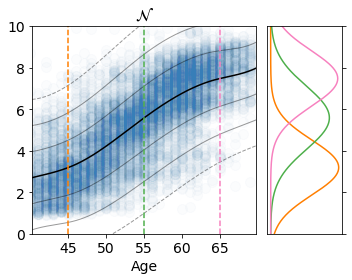

test1


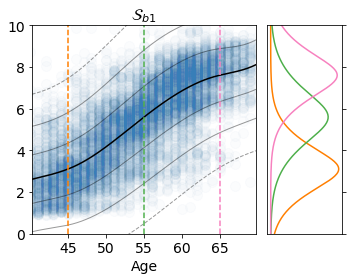

test1


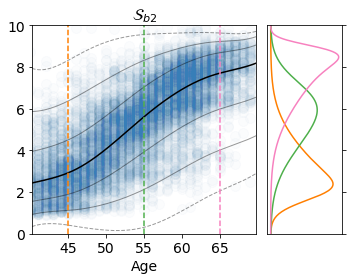

In [27]:
sex = 1
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
shashb_model_names = ['Normal','SHASHb_1','SHASHb_2']
for mn in shashb_model_names:
    X_train, Y_train, X_test, Y_test, Z = UMAP_data
    minx = np.min(X_train[:,0])
    maxx = np.max(X_train[:,0])
#     synthetic_X = np.arange(minx, maxx, 200)
    name = mn.replace("_","")

    with open(os.path.join(projdir,'Models',f'NM_0_0_UMAP{name}.pkl'),'rb') as file:
        model = pickle.load(file)
        models[d, mn] = model
        inscaler = scaler('standardize')
        outscaler = scaler('standardize')
        inscaler.fit(X_train)
        outscaler.fit(Y_train)
        this_X_test = inscaler.transform(X_test)
        this_Y_test = outscaler.transform(Y_test)
        X_test_transformed = bspline_transform(this_X_test,model.hbr.bsp)
        all_data[d,mn] = ptk.util.utils.expand_all(X_test_transformed, this_Y_test, Z_test)
    with open(os.path.join(projdir, f'MAP_UMAP_{mn}.pkl'),'rb') as file:
        MAP = pickle.load(file)
        maps[d, mn] = MAP
    fig, ax = plt.subplots(1,2,figsize=(5,4),gridspec_kw={'width_ratios':[3,1]}, sharey=True)
    ax = ax.flatten()
    ax[0].set_ylim(0, 10)
    print('test1')
    synthetic_X0 = np.linspace(minx+0.2, maxx-0.2, 200)[:,None]
    ax[0].set_xlim(minx+0.2,maxx-0.2)
    synthetic_X = np.concatenate((synthetic_X0, np.full(synthetic_X0.shape,sex)),axis = 1)
    synthetic_X_trans = inscaler.transform(synthetic_X)
    ran = np.arange(-3,4)
    q = outscaler.inverse_transform(get_single_quantiles(synthetic_X_trans,ran, model, [0],MAP))
    x = synthetic_X0
    for ir, r in enumerate(ran):
        if r == 0:
            ax[0].plot(x[:,0], q[:,ir], color = 'black')
        elif abs(r) == 3:
            ax[0].plot(x[:,0], q[:,ir], color = 'black', alpha =0.4, linestyle="--", linewidth = 1)

        else:
            ax[0].plot(x[:,0], q[:,ir], color = 'black', alpha =0.4, linewidth = 1)
    
    line1x = 45.
    line2x = 55.
    line3x = 65.
    linesy = [0,10]
    ax[0].plot([line1x, line1x], linesy, color=cols[1], linestyle = "--")
    ax[0].plot([line2x, line2x], linesy, color=cols[2], linestyle = "--")
    ax[0].plot([line3x, line3x], linesy, color=cols[3], linestyle = "--")

    testsample = np.array([[line1x,sex],[line2x,sex],[line3x, sex]])
    testsample_scaled = inscaler.transform(testsample)
    testsample_design = np.concatenate((testsample_scaled, bspline_transform(testsample_scaled, model.hbr.bsp)), axis = 1)
    params = forward(testsample_design, np.array([[0],[0], [0]]), model, MAP)
    axin1 = ax[1]
    axin1.set_xticks([])

    ran = np.linspace(linesy[0], linesy[1], 200)
    rantrans = outscaler.transform(ran)
    cond_ages = [45,55,65]
    if mn == 'Normal':
        for i in range(3):
            p = np.exp(pm.Normal.dist(params['mu'][i],params['sigma'][i]).logp(rantrans).eval())
            axin1.plot( p,ran, color=cols[i+1], label=cond_ages[i])
    else:
        for i in range(3):
            p = np.exp(SHASHb.dist(params['mu'][i],params['sigma'][i],params['epsilon'][i],params['delta'][i]).logp(rantrans).eval())
            axin1.plot(p,ran, color=cols[i+1], label=cond_ages[i])
    lmap = {'blr':'W-BLR','SHASHo':'$\mathcal{S}_o$', 'SHASHb_1':'$\mathcal{S}_{b1}$','SHASHb_2':'$\mathcal{S}_{b2}$',  'Normal':'$\mathcal{N}$'}
    ax[0].set_title(lmap[mn], fontsize=16)
#     plt.plot(synthetic_X0[:,0], outscaler.inverse_transform(q))
    idx = X_train[:,1] == sex
    ax[0].scatter(X_train[idx,0], Y_train[idx], alpha = 0.02, color = cols[0],s = 100)
    idx = X_test[:,1] == sex

#     ax[0].scatter(X_test[idx,0], Y_test[idx], alpha = 0.03, color = cols[1], s = 100)

#     ax[0].set_title('HBR-$\mathcal{S}_{b%s}$' % f'{count}', fontsize=14)
    ax[0].set_xlabel('Age',fontsize=14)
    ax[0].set_xticks([45,50,55,60,65])
    ax[1].yaxis.tick_right()
#     ax[1].legend(fontsize=13)
    plt.tight_layout()
    plt.savefig(f"/home/preclineu/stijdboe/Projects/MasterThesis/Latex/Thesis/imgs/quantiles-UMAPcomplex{mn}_sex={sex}.png",dpi=300)
    plt.show()


In [28]:
sex = 0
for ec, dc in zip(epsilon_confs,delta_confs):
    X_train, Y_train, Z_train,  X_test, Y_test, Z_test = Ventricle_data
    minx = np.min(X_train[:,0])
    maxx = np.max(X_train[:,0])
#     synthetic_X = np.arange(minx, maxx, 200)
    count = (1 if ec=='True' else 0) + (1 if dc == 'True' else 0) + 1
    print(count)
    with open(os.path.join(projdir,'Models',f'NM_0_0_Right-Lateral-VentricleSHASHb{ec}{dc}.pkl'),'rb') as file:
        model = pickle.load(file)
        models[d, ec, dc] = model
        inscaler = scaler('standardize')
        outscaler = scaler('standardize')
        inscaler.fit(X_train)
        outscaler.fit(Y_train)
        this_X_test = inscaler.transform(X_test)
        this_Y_test = outscaler.transform(Y_test)
        X_test_transformed = bspline_transform(this_X_test,model.hbr.bsp)
        all_data[d,ec,dc] = ptk.util.utils.expand_all(X_test_transformed, this_Y_test, Z_test)
    with open(os.path.join(projdir, f'MAP_Right-Lateral-Ventricle_SHASHb_{ec}_{dc}.pkl'),'rb') as file:
        MAP = pickle.load(file)
        maps[d, ec, dc] = MAP
    fig, ax = plt.subplots(1,2,figsize=(5,4),gridspec_kw={'width_ratios':[3,1]}, sharey=True)
    ax = ax.flatten()
    ax[0].set_ylim(-10000, 90000)
    model_be = [69]
    this_scaled_Y_train = outscaler.transform(Y_train)
    centered_Y_train = np.zeros_like(this_scaled_Y_train)
    this_scaled_X_train = inscaler.transform(X_train)
    mu_intercept_mu = MAP['mu_intercept_mu'].item()
    sigma_intercept_mu = MAP['sigma_intercept_mu'].item()
    offsets = MAP['offset_intercept_mu']
    model_offset_intercept_mu_be = offsets[model_be]

        # For each batch effect
    for be in np.unique(Z_train,axis = 0):
        this_offset_intercept = offsets[be]
        idx = (Z_train == be).all(1) 

        centered_Y_train[idx] = this_scaled_Y_train[idx]-sigma_intercept_mu*this_offset_intercept
#         idx = (Z_test == be).all(1) 
#         centered_Y_test[idx] = this_scaled_Y_test[idx]-sigma_intercept_mu*this_offset_intercept
    train_sex_idx = np.where(X_train[:,1]==sex)

    ax[0].scatter(inscaler.inverse_transform(this_scaled_X_train)[train_sex_idx,0], outscaler.inverse_transform(centered_Y_train[train_sex_idx,None]), alpha = 0.1, s = 12)
#     plt.scatter(inscaler.inverse_transform(this_scaled_X_test)[test_sex_idx,0], outscaler.inverse_transform(centered_Y_test[test_sex_idx,None]), alpha = 0.1, s = 12)

    synthetic_X0 = np.linspace(minx+0.2, maxx-0.2, 200)[:,None]
    synthetic_X = np.concatenate((synthetic_X0, np.full(synthetic_X0.shape,sex)),axis = 1)
    synthetic_X_trans = inscaler.transform(synthetic_X)
    ran = np.arange(-3,4)
    q = outscaler.inverse_transform(get_single_quantiles(synthetic_X_trans,ran, model, [0],MAP)-sigma_intercept_mu*offsets[tuple(model_be)])
    x = synthetic_X0
    for ir, r in enumerate(ran):
        if r == 0:
            ax[0].plot(x[:,0], q[:,ir], color = 'black')
        elif abs(r) == 3:
            ax[0].plot(x[:,0], q[:,ir], color = 'black', alpha =0.4, linestyle="--", linewidth = 1)

        else:
            ax[0].plot(x[:,0], q[:,ir], color = 'black', alpha =0.4, linewidth = 1)
    
    line1x = 10.
    line2x = 80.
    linesy = [-10000,90000]
    ax[0].plot([line1x, line1x], linesy, color=cols[1])
    ax[0].plot([line2x, line2x], linesy, color=cols[2])
    
    testsample = np.array([[line1x,sex],[line2x,sex]])
    testsample_scaled = inscaler.transform(testsample)
    testsample_design = np.concatenate((testsample_scaled, bspline_transform(testsample_scaled, model.hbr.bsp)), axis = 1)
    params = forward(testsample_design, np.array([[0],[0]]), model, MAP)
    axin1 = ax[1]
    axin1.set_xticks([])
    axin1.yaxis.tick_right()
    ax[0].ticklabel_format(axis = 'y',style='sci', scilimits = (0,0))
    ran = np.linspace(linesy[0], linesy[1], 200)
    rantrans = outscaler.transform(ran)
    for i in range(2):
        p = np.exp(SHASHb.dist(params['mu'][i],params['sigma'][i],params['epsilon'][i],params['delta'][i]).logp(rantrans).eval())
        axin1.plot( p, ran,color=cols[i+1])

#     plt.plot(synthetic_X0[:,0], outscaler.inverse_transform(q))
    idx = X_train[:,1] == sex
    ax[0].set_title('HBR-$\mathcal{S}_{b%s}$' % f'{count}')
    plt.tight_layout()
    plt.savefig(f"/home/preclineu/stijdboe/Projects/MasterThesis/Latex/Thesis/imgs/quantiles-Right-Lateral-Ventriclecomplex{ec}{dc}_sex={sex}.png",dpi=300)
    plt.show()


NameError: name 'epsilon_confs' is not defined